# Deep Learning - Final Project - Chest X-Ray Images Classification

#### Installing precondition assets and downloading the dataaset

In [ ]:
# Installing kaggle cli
! pip install -q kaggle

In [ ]:
# Uploading the kaggle.jsom token for kaggle cli
from google.colab import files
files.upload()
print("Done!")

Saving kaggle.json to kaggle.json
Done!


In [ ]:
# Setting directory and copying the kaggle.json file
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading dataset and unzip to asl folder
! kaggle datasets download 'paultimothymooney/chest-xray-pneumonia'
! mkdir medical
# Unziping the dataset
! unzip -q chest-xray-pneumonia.zip  -d medical

 99% 2.28G/2.29G [00:27<00:00, 141MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.4MB/s]


#### Importing the libraries for this project

In [ ]:
import numpy as np
from PIL import Image
import random
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
import shutil
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
# from sklearn.decomposition import PCA
# from scipy.ndimage import zoom
# from IPython.display import Image as Imageds, display
import matplotlib as mpl

#### General functions in use throughout the project

In [ ]:
# Extract embedding vectors from the trained classification model
# model: trained classification model
# images: input images ready for the model to receive.
def extract_embedding_vectors(model, image):
    embedding_vectors = model.predict(image)
    return embedding_vectors

# Opening an image and resizeing it to the desired size
# path - string to the image
# size - tuple (height, width)
def openImageAndResize(path, size):
  img = Image.open(path)
  img = img.resize(size)
  return img

def prepareImgToModelV1(img_path, size):
  img = openImageAndResize(img_path, size)
  tensor = np.array(img)
  tensor = np.expand_dims(tensor, axis=0)
  tensor = np.expand_dims(tensor, axis=-1)
  return tensor

# Preparing the image to the model, scailing and normolizing it, return a tensor
# image_path - string to the image location
# target_size - tuple (height, width)
def prepareImgToModel(image_path, target_size):
    # Read the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Normilized the image
    # normalized_image = image / 255.0
    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    # Reshape the image to match the required shape for the model input
    processed_image = resized_image.reshape(1, target_size[0], target_size[1], 1)
    return processed_image

# given the history of the model, print the Training loss and Validation loss
def printLosses(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.legend()
  plt.show()

# Same for Training Accuracy and Val Accuracy
def printAccuracy(history):
  plt.plot(history.history['accuracy'], label='Training accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

# Displaing an image using matplotlib
def ShowImg(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()


# Given tf.data.dataset returns a split of training and validation set.
def createTrainWithValidationData(dataset, percentage):
  # # Calculate the size of the validation set
  dataset_size = len(dataset)
  validation_size = int(percentage * dataset_size)
  # Shuffling the dataset
  dataset_shuffled = dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False)
  # Split the dataset into training and validation sets
  train_dataset = dataset_shuffled.skip(validation_size)
  val_dataset = dataset_shuffled.take(validation_size)
  return train_dataset, val_dataset

# Displaying an image with an prediction and the actual classification.
def showImgWithWithClassification(img, actual, prediction):
  plt.imshow(img)
  title = "Actual: "+actual+" ; Prediction: " + prediction
  plt.title(title)
  plt.axis('off')
  plt.show()

# Return the predicted label of the result from the network
def getPreidictionLabel(preidictionVector, labels):
  val = np.argmax(preidictionVector, axis=1)
  return labels[val[0]]

# generate a classic report on the test data with the given model.
def generateClassificationReport(model, test_dataset, class_names):
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset to extract true labels and make predictions
    for images, labels in test_dataset:
        true_labels.extend(labels.numpy())  # Extract true labels
        predictions = model.predict(images, verbose=0)  # Make predictions
        predicted_labels.extend(predictions.argmax(axis=1))  # Extract predicted labels

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Convert true labels to binary format if needed
    if true_labels.ndim > 1 and true_labels.shape[1] > 1:
        true_labels = np.argmax(true_labels, axis=1)

    # Generate classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    return report

# Create a folder
def createFolder(path):
  os.makedirs(path, exist_ok=True)

# Maybe not needed
def train_model(model, training_data, episode, validation_data):
  return model.fit(training_data, epochs=episode, validation_data=validation_data)

# Given tf.data.dataset returns a random image as a tensor ready for model.
def getRandomImageFromDataset(dataset):
    # Convert the dataset to a list
    image_list = list(dataset.as_numpy_iterator())
    # Choose a random index
    random_index = random.randint(0, len(image_list) - 1)
    # Extract a random image
    random_image = image_list[random_index][0]
    # If the image has a channel dimension, remove it
    if random_image.shape[-1] == 1:
        random_image = random_image.squeeze(axis=-1)
    return random_image

# From folder, getting a random image.
def getRandomImageFromPath(path, size):
    # Convert the dataset to a list
    lst = os.listdir(path)
    random_name = random.choice(lst)
    tensor = prepareImgToModel(path+"/"+random_name, size)
    return tensor


# given a autoencoder model and a folder path, checking the model on a random image from the folder.
def checkRandomImageFromData(dirPath, size, autoencoder_model):
    random_image = getRandomImageFromPath(dirPath, size)
    # Apply the autoencoder model to the random image
    reconstructed_image = autoencoder_model.predict(random_image)

    plt.figure(figsize=(10, 10))
    # Original image
    plt.subplot(1, 2, 2)
    plt.imshow(random_image.squeeze(axis=0), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    # Reconstructed image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image.squeeze(axis=0), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()

def display_image(numpy_array, title="Image"):
    # Ensure that the numpy array is in the range [0, 1]
    numpy_array = np.clip(numpy_array, 0.0, 1.0)
    # Remove the singleton dimension if present
    if len(numpy_array.shape) == 4:
        numpy_array = np.squeeze(numpy_array, axis=0)
    # Display the image using Matplotlib
    plt.title(title)
    # plt.imshow(numpy_array, cmap='gray')
    plt.imshow(numpy_array)
    plt.axis('off')
    plt.show()

#### Mounting to google drive (for saving the weights)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Task 1.a Classification of healthy/sick:
Develop a neural network model designed for binary classification, aiming to distinguish between healthy and sick individuals using X-ray images. The model comprises two output neurons dedicated to classifying the health status of the subjects.

In [ ]:
# Consts for this task
img_height_a = 128
img_width_a = 128
batch_size = 16

img_size_a = (img_height_a, img_width_a)

In [ ]:
# Working with the dataset
train_path = '/content/medical/chest_xray/train'
val_path = '/content/medical/chest_xray/val'
test_path = '/content/medical/chest_xray/test'

# Preproccessing the images, each image will be size 128x128x1
def getDataSet_a(path):
  return tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels = "inferred",
    label_mode = "categorical",
    color_mode = "grayscale",
    batch_size = batch_size,
    image_size = img_size_a,
)

train_ds_a = getDataSet_a(train_path)
val_ds_a = getDataSet_a(val_path)
class_labels_a = train_ds_a.class_names

# Creating different set
all_ds_train_val_a = train_ds_a.concatenate(val_ds_a)
train_ds_a, val_ds_a = createTrainWithValidationData(all_ds_train_val_a, 0.2)

# Test not touching.
test_ds_a = getDataSet_a(test_path)
class_labels_a

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


['NORMAL', 'PNEUMONIA']

#### Printing Example Images from the train test to check that they are loading correctly

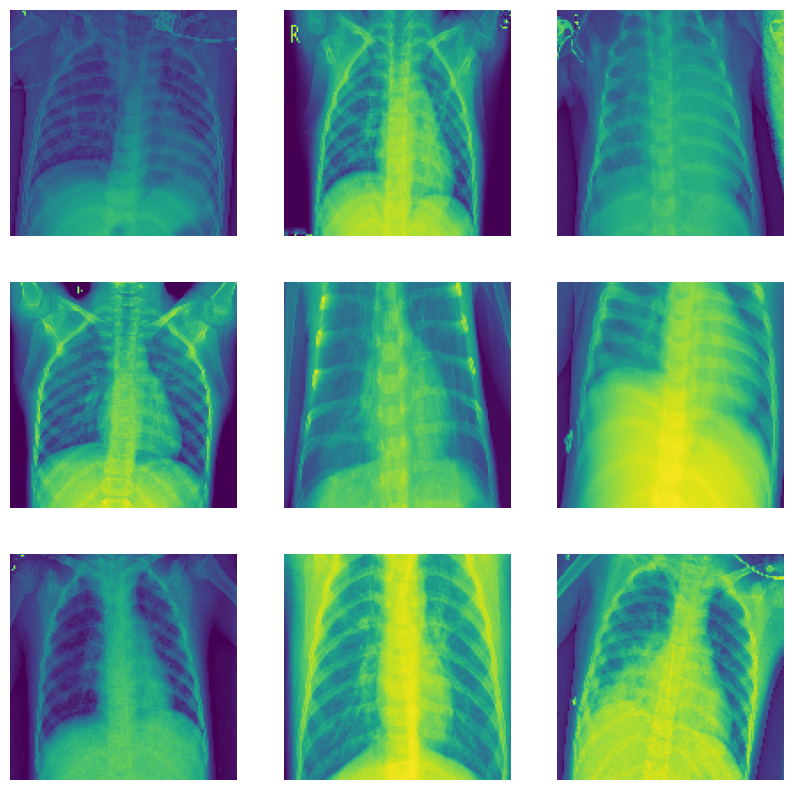

In [ ]:
plt.figure(figsize=(10,10))
for img, labels in train_ds_a.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(img[i]))
    plt.axis('off')

### Creating the model

In [ ]:
def create_model_task_one_a():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height_a, img_width_a, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])


  # Learning rate scheduling
    initial_learning_rate = 0.00005
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=1000,
      decay_rate=0.96,
      staircase=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

#### Creating the model and training it with early stopping incase the val_loss is not decreasing properly

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_a = create_model_task_one_a()
history_a = model_a.fit(train_ds_a, epochs=40, validation_data=val_ds_a, callbacks=[early_stopping])

Epoch 1/40
262/262 [==============================] - 70s 165ms/step - loss: 0.2015 - accuracy: 0.9339 - val_loss: 0.3696 - val_accuracy: 0.8202
Epoch 2/40
262/262 [==============================] - 51s 101ms/step - loss: 0.1160 - accuracy: 0.9594 - val_loss: 0.1386 - val_accuracy: 0.9548
Epoch 3/40
262/262 [==============================] - 50s 98ms/step - loss: 0.1085 - accuracy: 0.9645 - val_loss: 0.1587 - val_accuracy: 0.9413
Epoch 4/40
262/262 [==============================] - 54s 111ms/step - loss: 0.0812 - accuracy: 0.9721 - val_loss: 0.0363 - val_accuracy: 0.9885
Epoch 5/40
262/262 [==============================] - 52s 102ms/step - loss: 0.0727 - accuracy: 0.9773 - val_loss: 0.0367 - val_accuracy: 0.9837
Epoch 6/40
262/262 [==============================] - 51s 102ms/step - loss: 0.0647 - accuracy: 0.9790 - val_loss: 0.0269 - val_accuracy: 0.9933
Epoch 7/40
262/262 [==============================] - 49s 98ms/step - loss: 0.0503 - accuracy: 0.9821 - val_loss: 0.2192 - val_accu

In [ ]:
model_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)      

#### OR loading the models from given weights.

In [ ]:
# Uploading the weights file
model_a_weights = files.upload()
model_a_weigths_file_name = list(model_a_weights.keys())[0]

Saving model_1_A_V3.h5 to model_1_A_V3.h5


In [ ]:
model_a = create_model_task_one_a()
model_a.build(input_shape=(None, img_height_a, img_width_a, 1))
model_a.load_weights(model_a_weigths_file_name)

#### Save the weights to google drive

In [ ]:
model_a.save_weights('/content/drive/My Drive/model_1_A_V3.h5')

#### Task 1.a model results

In [ ]:
# Evaluating the model on the Test sets
test_loss_a, test_acc_a = model_a.evaluate(test_ds_a)
print("Test loss:", test_loss_a)
print("Test accuracy:", test_acc_a)

train_accuracy_a = history_a.history['accuracy'][-1]
val_accuracy_a = history_a.history['val_accuracy'][-1]

# Printing the success rate
print(f"Training Accuracy: {train_accuracy_a * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_a * 100:.2f}%")

39/39 [==============================] - 3s 53ms/step - loss: 1.2346 - accuracy: 0.7740
Test loss: 1.234620213508606
Test accuracy: 0.7740384340286255
Training Accuracy: 99.45%
Validation Accuracy: 99.81%


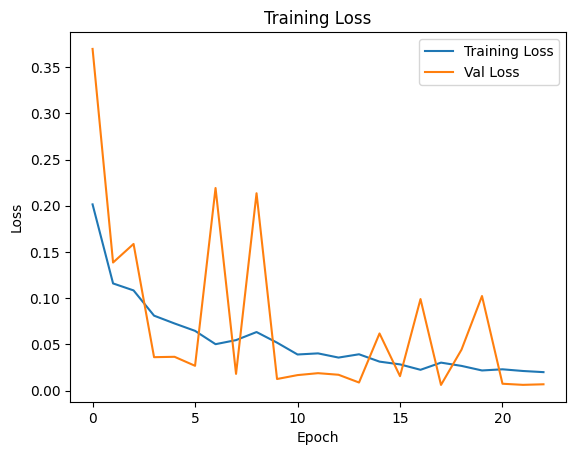

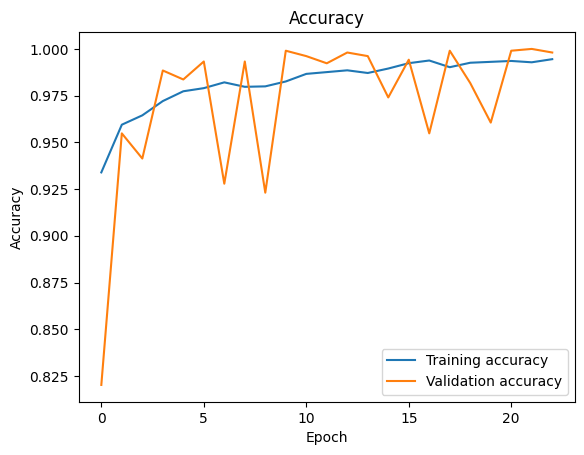

In [ ]:
# Diagram of the loss and accuracy
printLosses(history_a)
printAccuracy(history_a)

#### Testing with example
Taking two images, one NORMAL and the other PNEUMONIA, those images were taken from the 'test' folder.
We will classify the image by the model we just created and see if we get the expected result

In [ ]:
normal_example_a = '/content/medical/chest_xray/test/NORMAL/IM-0009-0001.jpeg'
pneumonia_example_a = '/content/medical/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg'

# Loading the image
normal_img_a = Image.open(normal_example_a)
pneumonia_img_a = Image.open(pneumonia_example_a)

# Function that takes a path to image -> shrink it -> adding channel and dims -> returns a tensor ready for the model
normal_tensor_a = prepareImgToModel(normal_example_a, img_size_a)
pneumonia_tensor_a = prepareImgToModel(pneumonia_example_a, img_size_a)

normal_tensor_a.shape, pneumonia_tensor_a.shape

((1, 128, 128, 1), (1, 128, 128, 1))

1/1 [==============================] - 0s 72ms/step


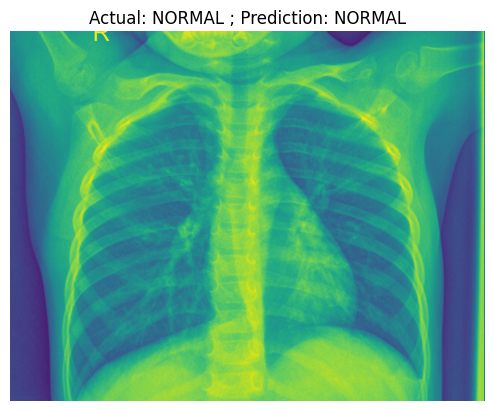

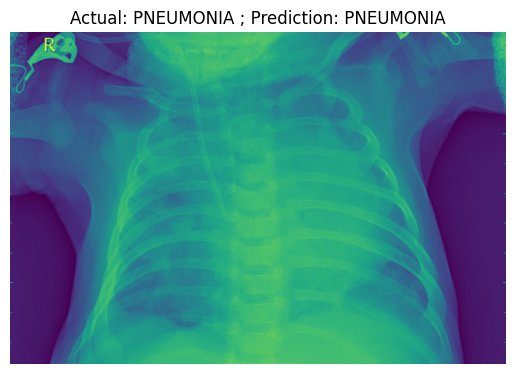

In [ ]:
normal_result_a = model_a.predict(normal_tensor_a)
pneumonia_result_a = model_a.predict(pneumonia_tensor_a)

normal_predicted_class_a = getPreidictionLabel(normal_result_a, class_labels_a)
pneumonia_predicted_class_a = getPreidictionLabel(pneumonia_result_a, class_labels_a)

# Showing the image that was classified with the predicted label from the model.
showImgWithWithClassification(normal_img_a, "NORMAL", normal_predicted_class_a)
showImgWithWithClassification(pneumonia_img_a, "PNEUMONIA", pneumonia_predicted_class_a)

#### Showing the classification report of Model 1.a

In [ ]:
report = generateClassificationReport(model_a, test_ds_a, class_labels_a)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.98      0.41      0.57       234
   PNEUMONIA       0.74      0.99      0.85       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624



## Task 1.b Classification of healthy/bactirial/viral:
In this task will make a classification network, just like 1.a but we will add another class, total 3 classes

#### Consts for this task

In [ ]:
# Consts for this task
img_height_b = 128
img_width_b = 128
batch_size_b = 32

img_size_b = (img_height_b, img_width_b)

#### Preparing the data for task 1.b
- Creating a copy for the x-rays folder that is structure looks like this
- chest_xray_modify (main folder)
    - train (sub flolder)
          - NORMAL (sub sub folder)
          - BACTERIA
          - VIRAL
    - test
          - NORMAL
          - BACTERIA
          - VIRAL
    - val
          - NORMAL
          - BACTERIA
          - VIRAL

Making this structure so i can work with the function "tf.keras.preprocessing.image_dataset_from_directory"

In [ ]:
# Working with the dataset
train_path = '/content/medical/chest_xray/train/'
val_path = '/content/medical/chest_xray/val/'
test_path = '/content/medical/chest_xray/test/'

data_path = '/content/medical/chest_xray_modify/'
data_path_train = '/content/medical/chest_xray_modify/train'
data_path_test = '/content/medical/chest_xray_modify/test'
data_path_val = '/content/medical/chest_xray_modify/val'


def handleFolderDataForTask_b(path, name):
  folder_list = os.listdir(path)
  # each file in the main folder is a folder
  createFolder(data_path+name+"/NORMAL")
  createFolder(data_path+name+"/BACTERIA")
  createFolder(data_path+name+"/VIRAL")

  # Creating a new folder structure so i can work with the ft.keras.preproceccing
  for folder in folder_list:
    if folder == "NORMAL":
      file_list = os.listdir(path + folder)
      for file_name in file_list:
        shutil.copy(path+"/"+folder+"/"+file_name, data_path+name+"/"+folder)
    if folder == "PNEUMONIA":
      file_list = os.listdir(path + folder)
      for file_name in file_list:
        if "bacteria" in file_name:
          shutil.copy(path+"/"+folder+"/"+file_name, data_path+name+"/"+"BACTERIA")
        if "virus" in file_name:
          shutil.copy(path+"/"+folder+"/"+file_name, data_path+name+"/"+"VIRAL")


handleFolderDataForTask_b(test_path, "test")
handleFolderDataForTask_b(train_path, "train")
handleFolderDataForTask_b(val_path, "val")


def getDataSet_b(path):
  return tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels = "inferred",
    label_mode = "categorical",
    color_mode = "grayscale",
    batch_size = batch_size_b,
    image_size = img_size_b,
)

# Preproccessing the images, each image will be size 128x128x1
train_ds_b = getDataSet_b(data_path_train)
val_ds_b = getDataSet_b(data_path_val)
class_labels_b = train_ds_b.class_names

# Creating different set
all_ds_train_val_b = train_ds_b.concatenate(val_ds_b)
train_ds_b, val_ds_b = createTrainWithValidationData(all_ds_train_val_b, 0.2)

# Test not changing
test_ds_b = getDataSet_b(data_path_test)
class_labels_b

Found 5216 files belonging to 3 classes.
Found 16 files belonging to 3 classes.
Found 624 files belonging to 3 classes.


['BACTERIA', 'NORMAL', 'VIRAL']

In [ ]:
def create_model_task_one_b():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height_b, img_width_b, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    initial_learning_rate = 0.0005
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

#### Creating the Model for task 1.b and training it using early stopping that keep track of the validation loss

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_b = create_model_task_one_b()
history_b = model_b.fit(train_ds_b, epochs=40, validation_data=val_ds_b, callbacks=[early_stopping])

Epoch 1/40
132/132 [==============================] - 54s 205ms/step - loss: 0.7243 - accuracy: 0.6747 - val_loss: 0.5121 - val_accuracy: 0.8008
Epoch 2/40
132/132 [==============================] - 51s 200ms/step - loss: 0.5431 - accuracy: 0.7671 - val_loss: 0.4533 - val_accuracy: 0.8037
Epoch 3/40
132/132 [==============================] - 49s 193ms/step - loss: 0.4883 - accuracy: 0.7792 - val_loss: 0.4360 - val_accuracy: 0.8096
Epoch 4/40
132/132 [==============================] - 51s 199ms/step - loss: 0.4629 - accuracy: 0.7959 - val_loss: 0.4300 - val_accuracy: 0.8115
Epoch 5/40
132/132 [==============================] - 52s 197ms/step - loss: 0.4546 - accuracy: 0.7954 - val_loss: 0.4427 - val_accuracy: 0.7939
Epoch 6/40
132/132 [==============================] - 50s 194ms/step - loss: 0.4395 - accuracy: 0.8004 - val_loss: 0.3803 - val_accuracy: 0.8320
Epoch 7/40
132/132 [==============================] - 66s 321ms/step - loss: 0.4159 - accuracy: 0.8182 - val_loss: 0.3825 - val_ac

In [ ]:
model_b.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 128)      

#### Saving the model weights for google drive

In [ ]:
model_b.save_weights('/content/drive/My Drive/model_1_B_V3.h5')

#### OR Load the model b from a given weights

In [ ]:
# Uploading the weights file
model_b_weights = files.upload()
model_b_weigths_file_name = list(model_b_weights.keys())[0]

Saving model_1_B_V3.h5 to model_1_B_V3.h5


In [ ]:
model_b = create_model_task_one_b()
model_b.build(input_shape=(None, img_height_b, img_width_b, 1))
model_b.load_weights(model_b_weigths_file_name)

#### Evaluating the model on the test dataset

In [ ]:
test_loss, test_acc = model_b.evaluate(test_ds_b)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

train_accuracy_b = history_b.history['accuracy'][-1]
val_accuracy_b = history_b.history['val_accuracy'][-1]

# Printing the success rate
print(f"Training Accuracy: {train_accuracy_b * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_b * 100:.2f}%")

20/20 [==============================] - 3s 106ms/step - loss: 4.0326 - accuracy: 0.6346
Test loss: 4.032639503479004
Test accuracy: 0.6346153616905212
Training Accuracy: 97.96%
Validation Accuracy: 99.61%


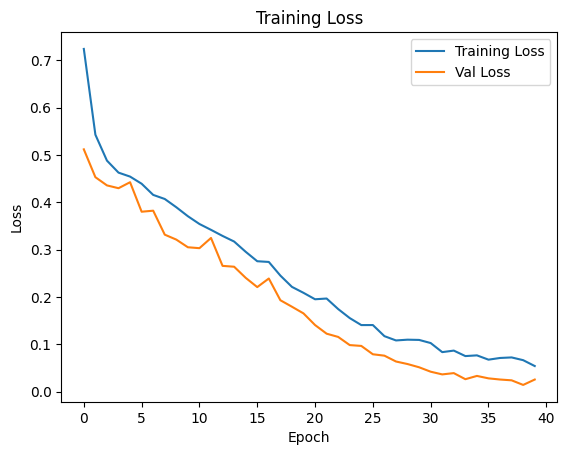

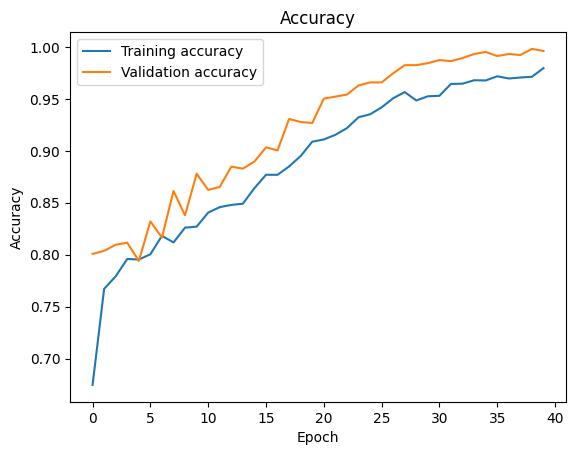

In [ ]:
# Diagram of the loss and accuracy
printLosses(history_b)
printAccuracy(history_b)

#### Testing with example
Taking 3 images, one NORMAL, BACTIRIAL, VIRAL, those images was taken from the 'test' folder
We will classify the images by the model we just created and see if we get the expected result

In [ ]:
normal_example_b = '/content/medical/chest_xray_modify/test/NORMAL/IM-0006-0001.jpeg'
bactirial_example_b = '/content/medical/chest_xray_modify/test/BACTERIA/person109_bacteria_519.jpeg'
viral_example_b = '/content/medical/chest_xray_modify/test/VIRAL/person1642_virus_2842.jpeg'

# Loading the images
normal_img_b = Image.open(normal_example_b)
bactirial_img_b = Image.open(bactirial_example_b)
viral_img_b = Image.open(viral_example_b)

normal_tensor_b = prepareImgToModel(normal_example_b, img_size_b)
bactirial_tensor_b = prepareImgToModel(bactirial_example_b, img_size_b)
viral_tensor_b = prepareImgToModel(viral_example_b, img_size_b)

normal_tensor_b.shape, bactirial_tensor_b.shape, viral_tensor_b.shape

((1, 128, 128, 1), (1, 128, 128, 1), (1, 128, 128, 1))

1/1 [==============================] - 0s 29ms/step


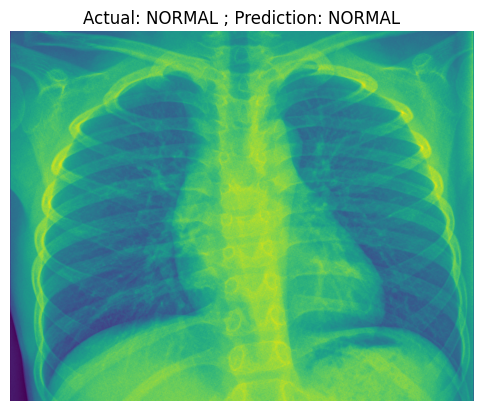

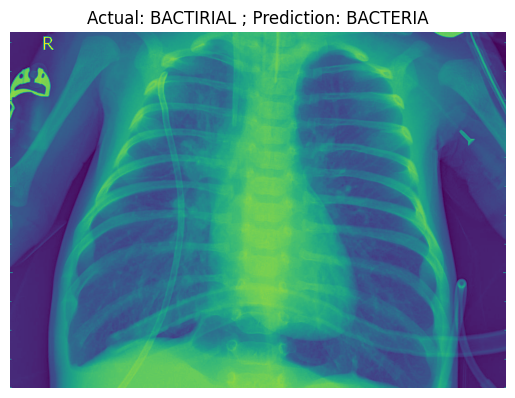

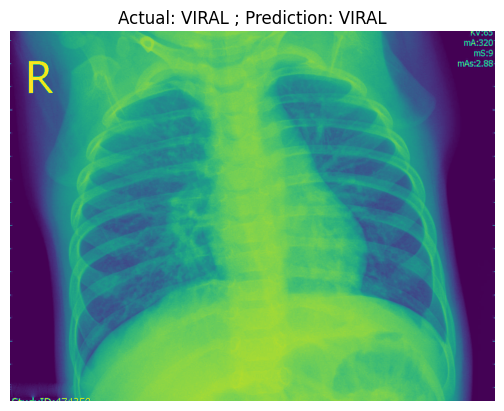

In [ ]:
normal_result_b = model_b.predict(normal_tensor_b)
bactirial_result_b = model_b.predict(bactirial_tensor_b)
viral_result_b = model_b.predict(viral_tensor_b)

normal_predicted_class = getPreidictionLabel(normal_result_b, class_labels_b)
bactirial_predicted_class = getPreidictionLabel(bactirial_result_b, class_labels_b)
viral_predicted_class = getPreidictionLabel(viral_result_b, class_labels_b)

# Showing the example images with predicted label from model_b
showImgWithWithClassification(normal_img_b, "NORMAL", normal_predicted_class)
showImgWithWithClassification(bactirial_img_b, "BACTIRIAL", bactirial_predicted_class)
showImgWithWithClassification(viral_img_b, "VIRAL", viral_predicted_class)

#### Showing classification Report for Model 1.b

In [ ]:
report_b = generateClassificationReport(model_b, test_ds_b, class_labels_b)
print(report_b)

              precision    recall  f1-score   support

    BACTERIA       0.66      0.93      0.77       242
      NORMAL       0.96      0.33      0.50       234
       VIRAL       0.46      0.63      0.53       148

    accuracy                           0.63       624
   macro avg       0.69      0.63      0.60       624
weighted avg       0.73      0.63      0.61       624



## Task 2 - Example and Visualization Using Embedding Vectors
In this task, we will utilize the model developed in Step 1.a and 1.b. Here are the steps involved:

1. Extracting the embedded vector for each category: NORMAL, BACTERIA, VIRAL for 1.b and NORMAL and SICK for 1.a.
2. Creating a KNN classifier using the t-SNE library with k=10.
3. Downloading a random x-ray image from Google.
4. Extracting the embedded vector of the new image obtained from Model 1.a and 1.b
5. Visualizing all three vectors: NORMAL, BACTERIA, VIRAL, along with the new image vector for task 1.b and for task 1.a only NORMAL and SICK.
6. Classifying the image using the KNN classifier.


### For Task 1.A

In [ ]:
data_path_train_task_1a = '/content/medical/chest_xray/train'

# Define paths for NORMAL and SICK path
train_normal_path = data_path_train_task_1a + "/NORMAL"
train_pneumonia_path = data_path_train_task_1a + "/PNEUMONIA"

normal_size = len(os.listdir(train_normal_path))
pneumonia_size = len(os.listdir(train_pneumonia_path))

def getDataSetTaskTwoFirst(path, label, sizeOfImages):
    if label == "NORMAL":
        label_value = 0
    elif label == "PNEUMONIA":
        label_value = 1
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=[label_value] * sizeOfImages,
        label_mode="int",
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=img_size_a,
    )

# Create tf.data.Dataset instances for NORMAL, BACTERIA and VIRAL images
train_normal_ds_2 = getDataSetTaskTwoFirst(train_normal_path, "NORMAL", normal_size)
train_pneumonia_ds_2 = getDataSetTaskTwoFirst(train_pneumonia_path, "PNEUMONIA", pneumonia_size)

Found 1341 files belonging to 1 classes.
Found 3875 files belonging to 1 classes.


#### Creating a new model of task 1.A that will output the one before the output layer.

In [ ]:
layers = model_a.layers
second_last_layer = layers[-2]
extractor_model_a = tf.keras.Model(inputs=model_a.input, outputs=second_last_layer.output)

#### Extracting the embedded vector:
Extracting both the prediction vector, the one that classifiy the input. and also extracting the embedded vector at the layer one before that.

In [ ]:
normal_embedded_vector = extract_embedding_vectors(extractor_model_a, train_normal_ds_2)
pneumonia_embedded_vector = extract_embedding_vectors(extractor_model_a, train_pneumonia_ds_2)

normal_embedded_vector_regular_model = extract_embedding_vectors(model_a, train_normal_ds_2)
pneumonia_embedded_vector_regular_model = extract_embedding_vectors(model_a, train_pneumonia_ds_2)

normal_embedded_vector.shape, normal_embedded_vector_regular_model.shape

243/243 [==============================] - 9s 36ms/step


((1341, 128), (1341, 2))

#### Uploading test image from the internet
image src

```
https://www.google.com/imgres?imgurl=https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_big_gallery.jpg&imgrefurl=https://radiopaedia.org/cases/normal-chest-x-ray&h=630&w=630&tbnid=zTJ937SDW95esM&source=sa.im&tbnh=204&tbnw=204&usg=AI4_-kSF7bhhBsdVzoLmJoD7PyW0CEgVuw&vet=1&docid=Y1P5p-Fptb_PIM
```

Saving new_image_xray.jpeg to new_image_xray.jpeg


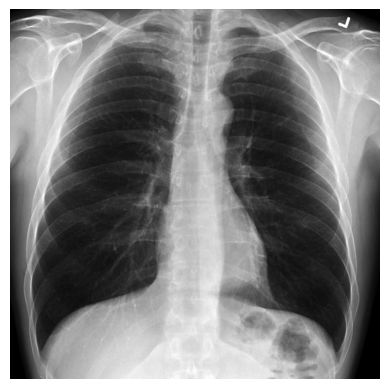

In [ ]:
uploaded = files.upload()
uploaded_image_path_first_task = list(uploaded.keys())[0]
new_img = Image.open("/content/" + uploaded_image_path_first_task)
ShowImg(new_img)

#### Preparing the new img to model 1.a and createing the embedded vector for the new image

In [ ]:
new_img_tensor_first_task = prepareImgToModel("/content/" + uploaded_image_path_first_task, img_size_a)
print("The new image shape after transform is:", new_img_tensor_first_task.shape)

The new image shape after transform is: (1, 128, 128, 1)


In [ ]:
embedded_vector_new_img_first_task = extractor_model_a.predict(new_img_tensor_first_task)
embbeded_vector_network_result = model_a.predict(new_img_tensor_first_task)
new_img_class_first_task = getPreidictionLabel(embbeded_vector_network_result, class_labels_a)
print("The new image was classified as: ", new_img_class_first_task)
embedded_vector_new_img_first_task, embedded_vector_new_img_first_task.shape

1/1 [==============================] - 0s 110ms/step
The new image was classified as:  PNEUMONIA


(array([[0.        , 0.        , 6.7815194 , 6.086558  , 2.9111998 ,
         1.8783998 , 0.        , 0.        , 2.7370331 , 0.        ,
         0.38707283, 2.2900712 , 0.        , 0.        , 0.        ,
         3.191963  , 0.        , 0.        , 0.        , 0.        ,
         0.17590198, 0.        , 0.19447887, 1.2663513 , 0.        ,
         0.        , 0.        , 5.848291  , 0.        , 0.84150594,
         1.7121284 , 0.        , 0.06968106, 0.        , 7.3005786 ,
         0.        , 0.        , 0.        , 2.6951857 , 0.        ,
         1.2646487 , 0.        , 0.        , 0.33017364, 0.        ,
         0.        , 0.        , 0.16587694, 3.8413866 , 0.        ,
         6.1618066 , 1.1159914 , 0.        , 0.53433305, 0.        ,
         0.        , 0.        , 0.        , 0.        , 2.6494179 ,
         0.        , 2.1362493 , 1.8323964 , 1.7515903 , 0.        ,
         0.32022193, 1.4425625 , 0.        , 0.        , 0.        ,
         0.31917647, 0.        , 3

#### Visualzing the embedded vector
We will start by visualzing the vector of the 'normal' and the 'pneumonia', those vector are in shape of (n, 128) where n is the number of samples that passed to the model, to visual it we take the mean of each one of them and producing vector in size of (1,128). we will visual it as an (x,y) graph.

The green color is the new image classification embedded vector took from the internet.

The red color is the 'penomonia' mean embedded vector (train set)

the blue color is the 'normal' mean embedded vector (train set)

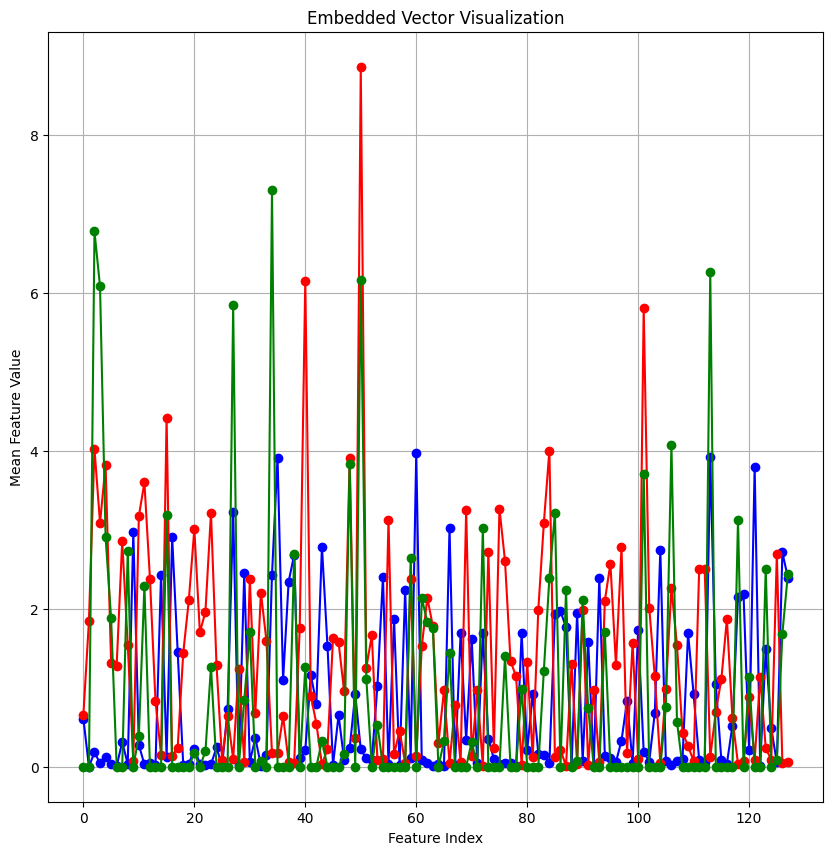

In [ ]:
def visual_embedded_vector(vectors, colors, labels):
    # Initialize an empty list to store mean feature vectors
    mean_feature_vectors = []

    # Calculate the mean feature vector for each input vector
    for vector in vectors:
        mean_feature_vector = np.mean(vector, axis=0)
        mean_feature_vectors.append(mean_feature_vector)

    # Plot each mean feature vector with corresponding color
    index = 0
    plt.figure(figsize=(10, 10))
    for mean_feature_vector, color in zip(mean_feature_vectors, colors):
        plt.plot(range(128), mean_feature_vector, marker='o', linestyle='-', color=color, label=labels[index])
        index += 1

    plt.title('Embedded Vector Visualization')
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Feature Value')
    plt.grid(True)
    plt.show()

vectors = [normal_embedded_vector, pneumonia_embedded_vector, embedded_vector_new_img_first_task]
colors = ['blue', 'red', 'green']
titles = ['Normal', 'Pneumonia', 'Image Sample']
visual_embedded_vector(vectors, colors, titles)

#### Visual the embedded vector as t-SNE display

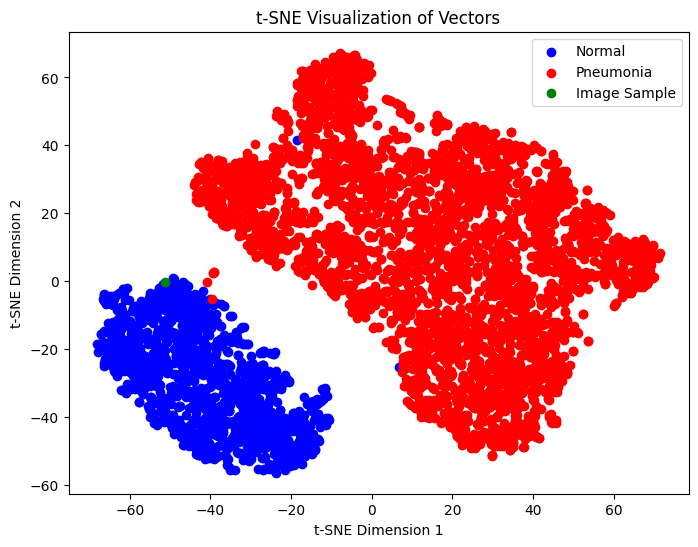

In [ ]:
def visualize_vectors_with_tsne(vectors, colors, labels):
    """
    This will be also for task 2.2 (Model 1.B)
    Visualize a list of vectors using t-SNE dimensionality reduction.

    Parameters:
        vectors (list of numpy arrays): List of vectors, each of shape (n, 128)
        colors (list of str): List of colors for each vector.
        labels (list of labels)
    """
    # Concatenate all vectors into a single matrix
    all_vectors = np.concatenate(vectors, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(all_vectors)

    # Plot the embeddings with corresponding colors
    plt.figure(figsize=(8, 6))
    for i, (vector, color) in enumerate(zip(vectors, colors)):
        start_index = sum(len(v) for v in vectors[:i])
        end_index = start_index + len(vector)
        plt.scatter(embeddings[start_index:end_index, 0], embeddings[start_index:end_index, 1], color=color, label=labels[i])

    # Customize plot
    plt.title('t-SNE Visualization of Vectors')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()

visualize_vectors_with_tsne(vectors, colors, titles)

#### Visualizing the 1.A network result on each data type with the new image sample
Here we are visualizing the network output result.
the new image sample is in color green.
the red are 'penumonia' and blue are 'normal'

this is extract visualing of the output nerual in 3D

In [ ]:
def visualize_embedded_vectors_3d_first_task(vectors, labels, colors, view_azim, view_elev):
    # Plot t-SNE embeddings of both vectors in 3D
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(vectors)):
      ax.scatter(vectors[i][:, 0], vectors[i][:, 1], label=labels[i], c=colors[i])
    ax.set_title("t-SNE Visualization of Embedded Vectors (3D)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(azim=view_azim, elev=view_elev)
    ax.legend()
    plt.show()

vectors_a = [normal_embedded_vector_regular_model, pneumonia_embedded_vector_regular_model, embbeded_vector_network_result]
labels_a = ["NORMAL", "PNEUMONIA", "NEW IMG SAMPLE"]
colors_a = ['b', 'r', 'green']

##### Visualing with 3 different angels where the 'NORMAL' are in blue, 'SICK' are in red and the new image is in black.

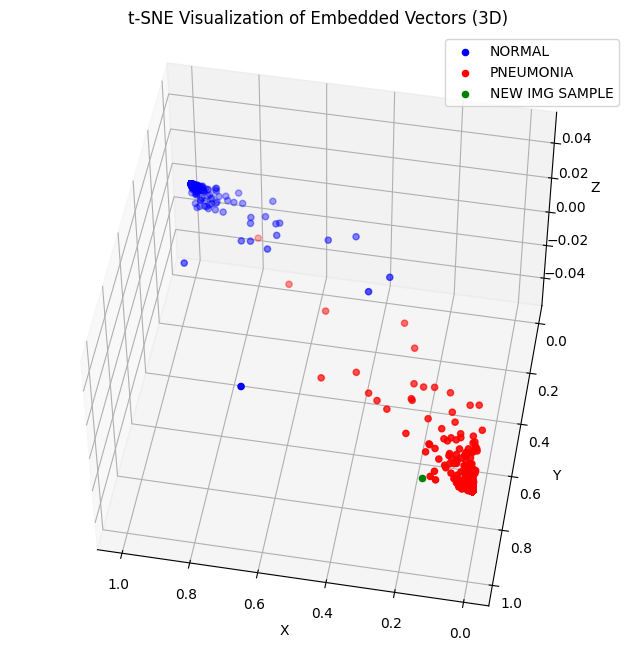

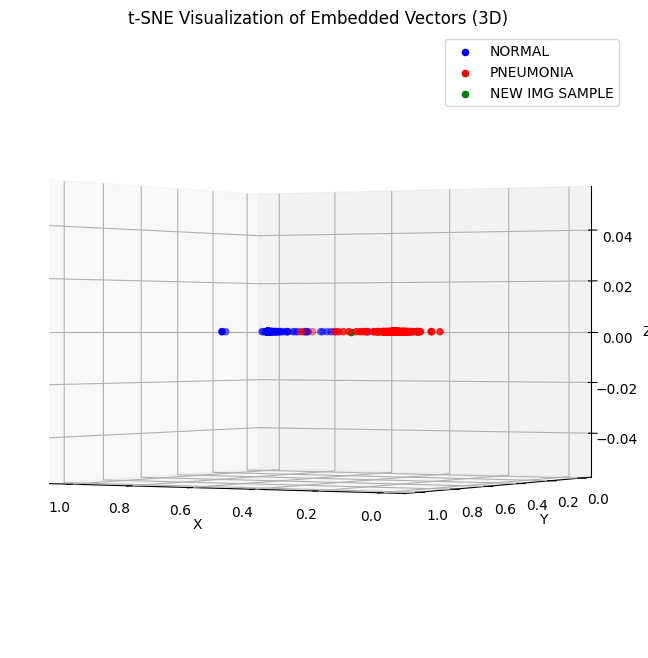

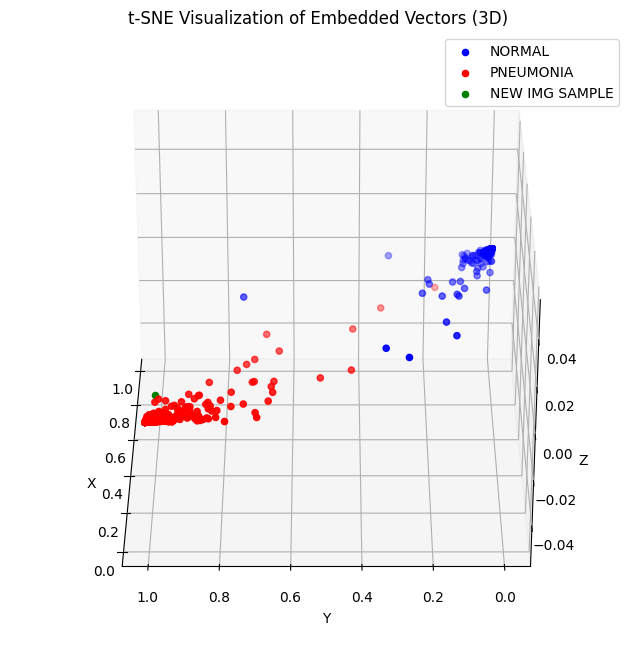

In [ ]:
visualize_embedded_vectors_3d_first_task(vectors_a, labels_a, colors_a, 100, 50)
visualize_embedded_vectors_3d_first_task(vectors_a, labels_a, colors_a, 120, 0)
visualize_embedded_vectors_3d_first_task(vectors_a, labels_a, colors_a, 180, 30)

#### Using KNN to classifiy the new embedded vector from Task 1.A
We will use the from sklearn.neighbors import KNeighborsClassifier to classifiy
Steps:
- Creating a concatination for all the trained embedded vectors
- Same for the labels
- Creating the KNN classifier with neighbors is 10
- Predicting the label of the new img using the .predict method in the KNN class

**We will use the embedded vector that was taken from one layer before the output layer**

In [ ]:
# Creating an embedded vector for all the train data
all_embedded_vectors_a = np.concatenate((normal_embedded_vector, pneumonia_embedded_vector))
# Combine all labels into one array
all_labels_a = np.concatenate((["NORMAL"] * len(normal_embedded_vector), ["PNEUMONIA"] * len(pneumonia_embedded_vector)))

# Create a KNN classifier
knn_classifier_first_task = KNeighborsClassifier(n_neighbors=10)

# Train the classifier
knn_classifier_first_task.fit(all_embedded_vectors_a, all_labels_a)

KNeighborsClassifier(n_neighbors=10)

##### Testing the new KNN algorithm with the new image sample

In [ ]:
# Classify the new data point
predicted_label_a = knn_classifier_first_task.predict(embedded_vector_new_img_first_task)
print("The New Image Predicted label is:", predicted_label_a[0], "By the KNN Algorithm.")

The New Image Predicted label is: NORMAL By the KNN Algorithm.


##### Testing the KNN algorithm with all the test data set

In [ ]:
data_path_test_task_1a = '/content/medical/chest_xray/test'

# Define paths for NORMAL and SICK path
test_normal_path = data_path_test_task_1a + "/NORMAL"
test_pneumonia_path = data_path_test_task_1a + "/PNEUMONIA"

normal_test_size = len(os.listdir(test_normal_path))
pneumonia_test_size = len(os.listdir(test_pneumonia_path))

# Create tf.data.Dataset instances for NORMAL, BACTERIA and VIRAL images
test_normal_ds_2 = getDataSetTaskTwoFirst(test_normal_path, "NORMAL", normal_test_size)
test_pneumonia_ds_2 = getDataSetTaskTwoFirst(test_pneumonia_path, "PNEUMONIA", pneumonia_test_size)

# Making all the test data.
all_test_data = test_normal_ds_2.concatenate(test_pneumonia_ds_2)
all_test_data.shuffle(buffer_size=10)

Found 234 files belonging to 1 classes.
Found 390 files belonging to 1 classes.


<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

##### Creating the embedded test data for all the test data to evaluate the KNN algorithm score

In [ ]:
normal_test_embedded_vector = extract_embedding_vectors(extractor_model_a, test_normal_ds_2)
pneumonia_test_embedded_vector = extract_embedding_vectors(extractor_model_a, test_pneumonia_ds_2)
normal_test_embedded_vector.shape, pneumonia_test_embedded_vector.shape

25/25 [==============================] - 1s 26ms/step


((234, 128), (390, 128))

##### Calculating the score of the KNN for each labels
'NORMAL' x-rays (test)

In [ ]:
test_accuracy_normal = knn_classifier_first_task.score(normal_test_embedded_vector, ['NORMAL']*normal_test_size)
test_accuracy_normal

0.4230769230769231

'PNEUMONIA' x-rays (test)

In [ ]:
test_accuracy_pneumonia = knn_classifier_first_task.score(pneumonia_test_embedded_vector, ['PNEUMONIA']*pneumonia_test_size)
test_accuracy_pneumonia

0.9974358974358974

##### Calculating the general score of the KNN on all the test data

In [ ]:
test_accuracy_general = knn_classifier_first_task.score(all_embedded_vectors_a, all_labels_a)
test_accuracy_general

0.9994248466257669

### For Task 1.B

#### Creating the tf.data.Dataset for all 3 categories, taking only from the 'train' folder

In [ ]:
data_path_train = '/content/medical/chest_xray_modify/train'

# Define paths for NORMAL, BACTERIA and VIRAL images
train_normal_path = data_path_train + "/NORMAL"
train_bactiria_path = data_path_train + "/BACTERIA"
train_viral_path = data_path_train + "/VIRAL"

normal_size = len(os.listdir(train_normal_path))
bactiria_size = len(os.listdir(train_bactiria_path))
viral_size = len(os.listdir(train_viral_path))

def getDataSetTaskTwo(path, label, sizeOfImages):
    if label == "NORMAL":
        label_value = 0
    elif label == "BACTERIA":
        label_value = 1
    elif label == "VIRAL":
        label_value = 2
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=[label_value] * sizeOfImages,
        label_mode="int",
        color_mode="grayscale",
        batch_size=batch_size_b,
        image_size=img_size_b,
    )

# Create tf.data.Dataset instances for NORMAL, BACTERIA and VIRAL images
train_normal_ds_2 = getDataSetTaskTwo(train_normal_path, "NORMAL", normal_size)
train_bactria_ds_2 = getDataSetTaskTwo(train_bactiria_path, "BACTERIA", bactiria_size)
train_viral_ds_2 = getDataSetTaskTwo(train_viral_path, "VIRAL", viral_size)

Found 1341 files belonging to 1 classes.
Found 2530 files belonging to 1 classes.
Found 1345 files belonging to 1 classes.


#### Creating a new model of task 1.B that will output the one before the output layer.

In [ ]:
layers = model_b.layers
second_last_layer = layers[-2]
extractor_model_b = tf.keras.Model(inputs=model_b.input, outputs=second_last_layer.output)

#### Extracting the embedded vector:
Extracting both the prediction vector, the one that classifiy the input. and also extracting the embedded vector at the layer one before that.

In [ ]:
# Embedded vector
normal_embedded_vector = extract_embedding_vectors(extractor_model_b, train_normal_ds_2)
bactiria_embedded_vector = extract_embedding_vectors(extractor_model_b, train_bactria_ds_2)
viral_embedded_vector = extract_embedding_vectors(extractor_model_b, train_viral_ds_2)
# The output vectors
normal_embedded_vector_regular_model = extract_embedding_vectors(model_b, train_normal_ds_2)
bactiria_embedded_vector_regular_model = extract_embedding_vectors(model_b, train_bactria_ds_2)
viral_embedded_vector_regular_model = extract_embedding_vectors(model_b, train_viral_ds_2)
normal_embedded_vector.shape, normal_embedded_vector_regular_model.shape

43/43 [==============================] - 3s 64ms/step


((1341, 128), (1341, 3))

#### Uploading test image from the internet
image src

```
https://www.google.com/imgres?imgurl=https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_big_gallery.jpg&imgrefurl=https://radiopaedia.org/cases/normal-chest-x-ray&h=630&w=630&tbnid=zTJ937SDW95esM&source=sa.im&tbnh=204&tbnw=204&usg=AI4_-kSF7bhhBsdVzoLmJoD7PyW0CEgVuw&vet=1&docid=Y1P5p-Fptb_PIM
```

Saving new_image_xray.jpeg to new_image_xray (1).jpeg


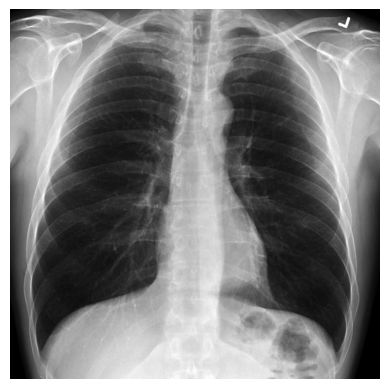

In [ ]:
uploaded = files.upload()
uploaded_image_path = list(uploaded.keys())[0]
new_img = Image.open("/content/" + uploaded_image_path)
ShowImg(new_img)

#### Preparing the new img to model 1.b and createing the embedded vector for the new image

In [ ]:
new_img_tensor = prepareImgToModel("/content/" + uploaded_image_path, img_size_b)
print("The new image shape after transform is:", new_img_tensor.shape)

The new image shape after transform is: (1, 128, 128, 1)


In [ ]:
embedded_vector_new_img_second_task = extractor_model_b.predict(new_img_tensor)
embbeded_vector_network_result = model_b.predict(new_img_tensor)
new_img_class = getPreidictionLabel(embbeded_vector_network_result, class_labels_b)

print("The new image was classified as: ", new_img_class)
embedded_vector_new_img_second_task, embedded_vector_new_img_second_task.shape

1/1 [==============================] - 0s 19ms/step
The new image was classified as:  BACTERIA


(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 5.6728168 , 0.        , 0.        , 0.        ,
         9.325838  , 0.        , 4.520654  , 0.        , 0.        ,
         0.        , 4.5762987 , 2.488082  , 0.33576792, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         5.3353662 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 3.299669  , 0.        , 0.        , 0.        ,
         0.04531419, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.98060185,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

#### Visualzing the embedded vector
We will start by visualzing the vector of the 'normal', 'bactirial', 'viral', those vector are in shape of (n, 64) where n is the number of samples the passed to the model, to visual it we take the mean of each one of them and producing vector in size of (1,64). we will visual it as an (x,y) graph.

The green color is the new image classification embedded vector took from the internet.

The red color is the 'Bactiria' mean embedded vector (train set)

the blue color is the 'Normal' mean embedded vector (train set)

the Cyan color is the 'Viral' mean embedded vector (train set)

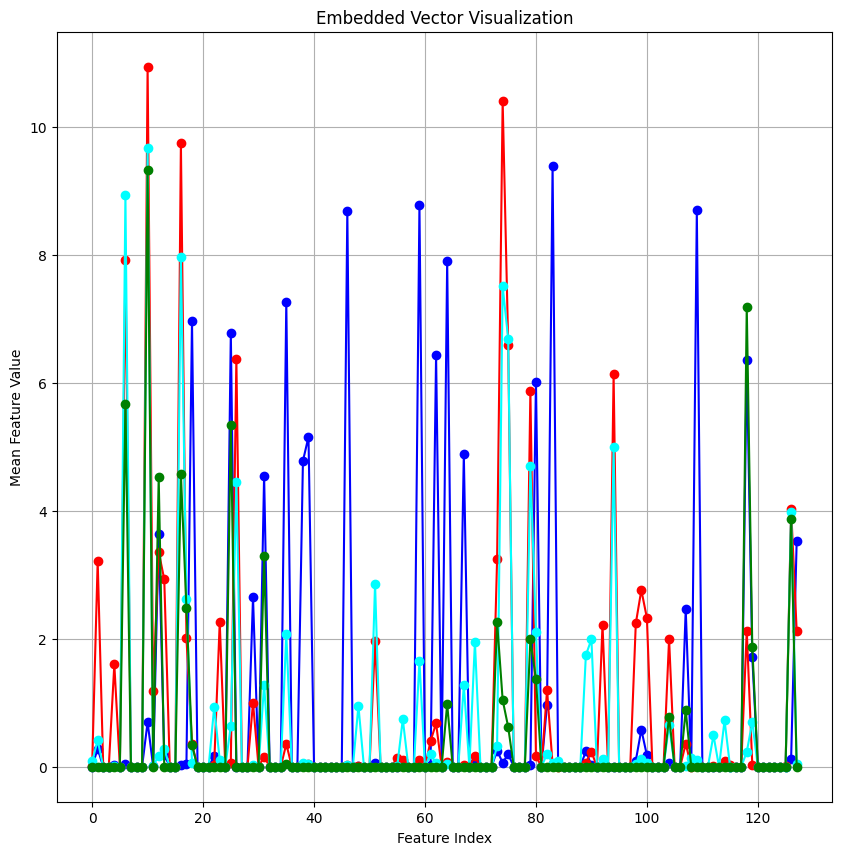

In [ ]:
def visual_embedded_vector_second_task(vectors, colors, labels):
    # Initialize an empty list to store mean feature vectors
    mean_feature_vectors = []

    # Calculate the mean feature vector for each input vector
    for vector in vectors:
        mean_feature_vector = np.mean(vector, axis=0)
        mean_feature_vectors.append(mean_feature_vector)

    # Plot each mean feature vector with corresponding color
    index = 0
    plt.figure(figsize=(10, 10))
    for mean_feature_vector, color in zip(mean_feature_vectors, colors):
        plt.plot(range(128), mean_feature_vector, marker='o', linestyle='-', color=color, label=labels[index])
        index += 1

    plt.title('Embedded Vector Visualization')
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Feature Value')
    plt.grid(True)
    plt.show()

vectors = [normal_embedded_vector, bactiria_embedded_vector, viral_embedded_vector, embedded_vector_new_img_second_task]
colors = ['blue', 'red', 'cyan','green']
titles = ['Normal', 'Bactiria', 'Viral', 'Image Sample']
visual_embedded_vector_second_task(vectors, colors, titles)

In [ ]:
def visualize_embedded_vectors_3d(vectors, labels, colors, view_azim, view_elev):
    # Plot t-SNE embeddings of both vectors in 3D
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(vectors)):
      ax.scatter(vectors[i][:, 0], vectors[i][:, 1], vectors[i][:, 2], label=labels[i], c=colors[i])
    ax.set_title("t-SNE Visualization of Embedded Vectors (3D)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(azim=view_azim, elev=view_elev)
    ax.legend()
    plt.show()

vectors = [normal_embedded_vector_regular_model, bactiria_embedded_vector_regular_model, viral_embedded_vector_regular_model, embbeded_vector_network_result]
labels = ["NORMAL", "BACTERIA", "VIRAL", "NEW IMG SAMPLE"]
colors = ['b', 'r', 'c', 'g']

#### Visual the embedded vector as t-SNE display

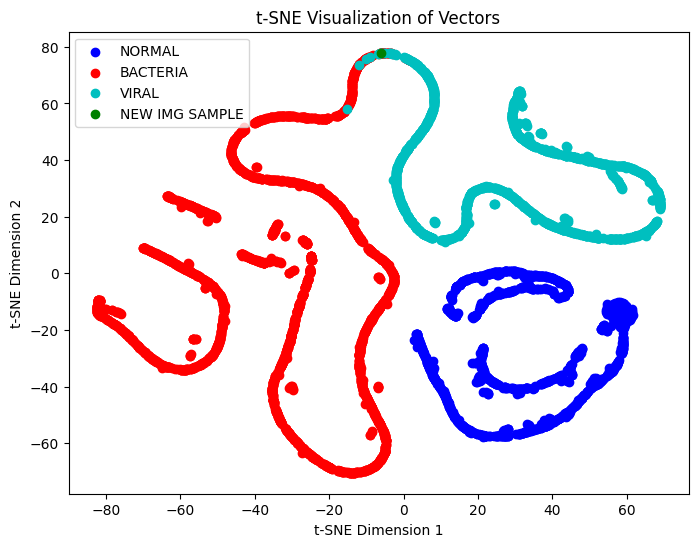

In [ ]:
visualize_vectors_with_tsne(vectors, colors, labels)

#### Visualing with 3 different angels where each embbeded vector Has different color
The sample image is in greem color

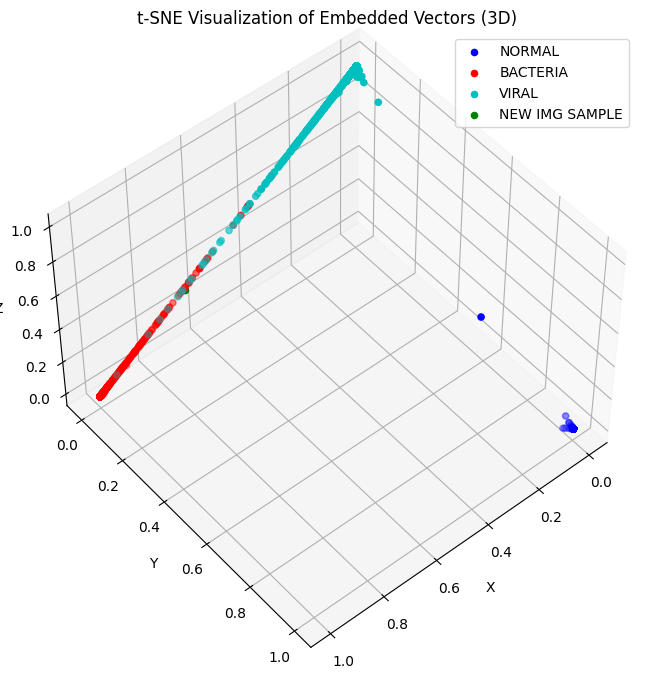

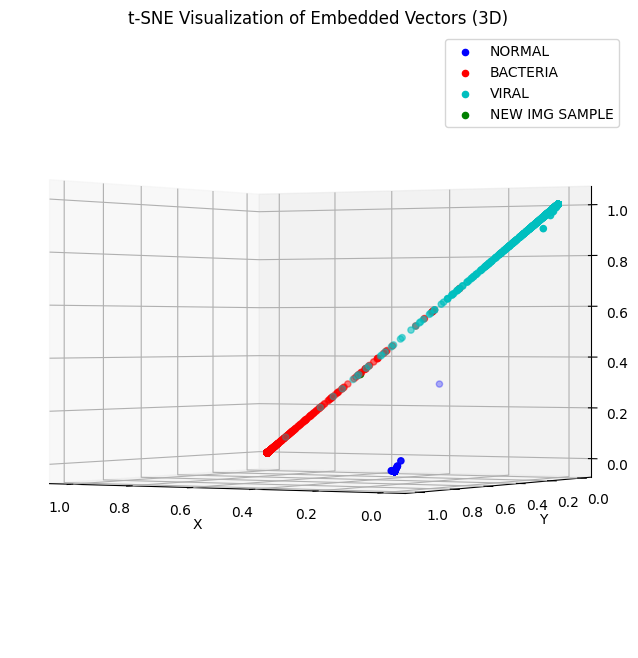

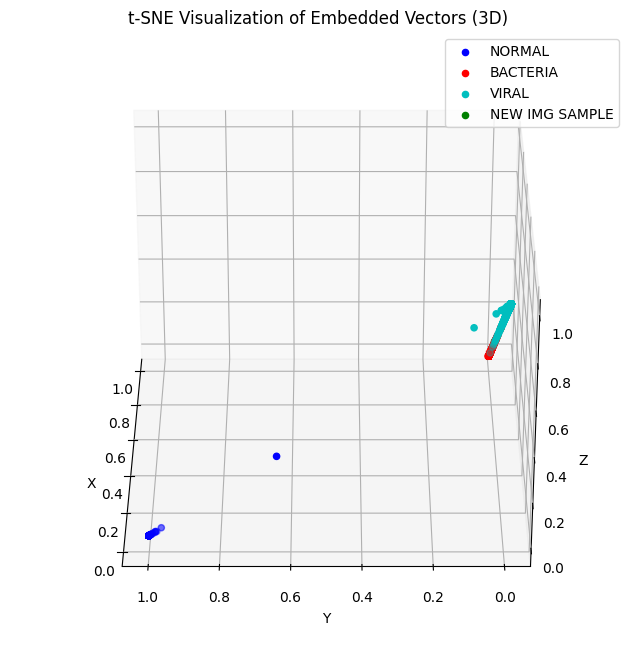

In [ ]:
visualize_embedded_vectors_3d(vectors, labels, colors, 50, 50)
visualize_embedded_vectors_3d(vectors, labels, colors, 120, 0)
visualize_embedded_vectors_3d(vectors, labels, colors, 180, 30)

#### Using KNN to classifiy the new embedded vector
We will use the from sklearn.neighbors import KNeighborsClassifier to classifiy
Steps:
- Creating a concatination for all the trained embedded vectors
- Same for the labels
- Creating the KNN classifier with neighbors is 10
- Predicting the label of the new img using the .predict method in the KNN class

In [ ]:
# Creating an embedded vector for all the train data
all_embedded_vectors = np.concatenate((normal_embedded_vector, bactiria_embedded_vector, viral_embedded_vector))

# Combine all labels into one array
all_labels = np.concatenate((["NORMAL"] * len(normal_embedded_vector), ["BACTERIA"] * len(bactiria_embedded_vector), ["VIRAL"] * len(viral_embedded_vector)))

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)

# Train the classifier
knn_classifier.fit(all_embedded_vectors, all_labels)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
# Classify the new data point
predicted_label = knn_classifier.predict(embedded_vector_new_img_second_task)
print("The New Image Predicted label is:", predicted_label[0], "By the KNN Algorithm.")

The New Image Predicted label is: VIRAL By the KNN Algorithm.


##### Testing the KNN algorithm with all the test data set

In [ ]:
data_path_test_task_1b = '/content/medical/chest_xray_modify/test'

# Define paths for NORMAL and VIRAL and BACTIRIAL path
test_normal_path = data_path_test_task_1b + "/NORMAL"
test_viral_path = data_path_test_task_1b + "/VIRAL"
test_bacteria_path = data_path_test_task_1b + "/BACTERIA"


normal_test_size = len(os.listdir(test_normal_path))
viral_test_size = len(os.listdir(test_viral_path))
bacteria_test_size = len(os.listdir(test_bacteria_path))

# Create tf.data.Dataset instances for NORMAL, BACTERIA and VIRAL images
test_normal_ds_2 = getDataSetTaskTwo(test_normal_path, "NORMAL", normal_test_size)
test_viral_ds_2 = getDataSetTaskTwo(test_viral_path, "VIRAL", viral_test_size)
test_bacteria_ds_2 = getDataSetTaskTwo(test_bacteria_path, "BACTERIA", bacteria_test_size)

Found 234 files belonging to 1 classes.
Found 148 files belonging to 1 classes.
Found 242 files belonging to 1 classes.


##### Creating the embedded test data

In [ ]:
normal_test_embedded_vector = extract_embedding_vectors(extractor_model_b, test_normal_ds_2)
viral_test_embedded_vector = extract_embedding_vectors(extractor_model_b, test_viral_ds_2)
bacteria_test_embedded_vector = extract_embedding_vectors(extractor_model_b, test_bacteria_ds_2)

normal_test_embedded_vector.shape, viral_test_embedded_vector.shape, bacteria_test_embedded_vector.shape

8/8 [==============================] - 1s 16ms/step


((234, 128), (148, 128), (242, 128))

##### Calculating the score of the KNN for each labels
'Normal' x-rays (test)

In [ ]:
test_accuracy_normal = knn_classifier.score(normal_test_embedded_vector, ['NORMAL']*normal_test_size)
test_accuracy_normal

0.31196581196581197

'VIRAL' x-rays (test)

In [ ]:
test_accuracy_viral = knn_classifier.score(viral_test_embedded_vector, ['VIRAL']*viral_test_size)
test_accuracy_viral

0.6081081081081081

'BACTERIA' x-rays (test)

In [ ]:
test_accuracy_bacteria = knn_classifier.score(bacteria_test_embedded_vector, ['BACTERIA']*bacteria_test_size)
test_accuracy_bacteria

0.9380165289256198

##### Calculating the general score of the KNN on all the test data

In [ ]:
test_accuracy = knn_classifier.score(all_embedded_vectors, all_labels)
test_accuracy

0.9963573619631901

## Task 3 - Anomaly Detection Methods

### Steps:
1. Implement a Convolutional Autoencoder.
2. Train the autoencoder on normal X-ray images.
3. Evaluate the trained autoencoder on abnormal X-ray images to detect anomalies.


#### Consts for this task

In [ ]:
# Consts for this task
img_height_3 = 128
img_width_3 = 128
batch_size_3 = 32
img_size_3 = (img_height_3, img_width_3)

#### Defining the Network Architecture of the AutoEncoder

- The network is designed to take input images and reconstruct them.
- If the input image differs from the output reconstruction beyond a certain threshold, it will be classified as an "Anomaly."


In [ ]:
def build_autoencoder(input_shape):
    # Encoder
    encoder_input = tf.keras.layers.Input(shape=input_shape, name='encoder_input')
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoder_output = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build autoencoder model
    autoencoder = tf.keras.models.Model(encoder_input, decoder_output, name='autoencoder')
    return autoencoder

shape = (img_height_3, img_width_3, 3)
autoencoder = build_autoencoder(shape)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.build(input_shape=shape)

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        

#### Preparing the "Healthy" dataset
Taking all the NORMAL images from each folder: train, val, test and adding it to a the same folder

In [ ]:
healthy_train_data_path = "/content/medical/chest_xray/train/NORMAL"
healthy_test_data_path = "/content/medical/chest_xray/test/NORMAL"
healthy_val_data_path = "/content/medical/chest_xray/val/NORMAL"

# Creating folder named TASK_3
FOLDER = "NORMAL_IMAGES"

FOLDER_VALIDATION = FOLDER+"/validation"
FOLDER_TRAIN = FOLDER+"/train"
FOLDER_TEST = FOLDER+"/test"

FULL_FOLDER_VALIDATION = FOLDER_VALIDATION+"/NORMAL"
FULL_FOLDER_TRAIN = FOLDER_TRAIN+"/NORMAL"
FULL_FOLDER_TEST = FOLDER_TEST+"/NORMAL"

# Main folder
createFolder(FOLDER)

# sub-folder
createFolder(FOLDER_VALIDATION)
createFolder(FOLDER_TRAIN)
createFolder(FOLDER_TEST)

# sub-sub-folder
createFolder(FULL_FOLDER_VALIDATION)
createFolder(FULL_FOLDER_TRAIN)
createFolder(FULL_FOLDER_TEST)


def handleFolderDataForTask_3(path, folder):
  folder_files = os.listdir(path)
  # Copying each file from the folder:
  for file in folder_files:
    shutil.copy(path+"/"+file, folder)


handleFolderDataForTask_3(healthy_train_data_path, FULL_FOLDER_TRAIN)
handleFolderDataForTask_3(healthy_test_data_path, FULL_FOLDER_TEST)
handleFolderDataForTask_3(healthy_val_data_path, FULL_FOLDER_VALIDATION)

#### Loading the data using keras flow_from_directory
Utilizing Keras flow_from_directory method for loading the data, we implement a technique known as Data Augmentation for the training data.

In [ ]:
# For the training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For the validation data
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    FOLDER_TRAIN,
    target_size=img_size_3,
    batch_size=batch_size_3,
    class_mode='input',
)
validation_generator = validation_datagen.flow_from_directory(
    FOLDER_VALIDATION,
    target_size=img_size_3,
    batch_size=batch_size_3,
    class_mode='input',
)

Found 1341 images belonging to 1 classes.
Found 8 images belonging to 1 classes.


#### Training the model with the Healthy data

In [ ]:
history_3 = autoencoder.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
)

Epoch 1/40
42/42 [==============================] - 35s 683ms/step - loss: 0.0275 - accuracy: 0.3066 - val_loss: 0.0088 - val_accuracy: 0.1893
Epoch 2/40
42/42 [==============================] - 29s 687ms/step - loss: 0.0071 - accuracy: 0.2840 - val_loss: 0.0061 - val_accuracy: 0.2412
Epoch 3/40
42/42 [==============================] - 32s 754ms/step - loss: 0.0055 - accuracy: 0.3084 - val_loss: 0.0052 - val_accuracy: 0.3007
Epoch 4/40
42/42 [==============================] - 29s 692ms/step - loss: 0.0050 - accuracy: 0.3147 - val_loss: 0.0048 - val_accuracy: 0.3319
Epoch 5/40
42/42 [==============================] - 30s 705ms/step - loss: 0.0046 - accuracy: 0.3210 - val_loss: 0.0044 - val_accuracy: 0.3259
Epoch 6/40
42/42 [==============================] - 30s 695ms/step - loss: 0.0043 - accuracy: 0.3218 - val_loss: 0.0051 - val_accuracy: 0.3598
Epoch 7/40
42/42 [==============================] - 29s 696ms/step - loss: 0.0040 - accuracy: 0.3223 - val_loss: 0.0043 - val_accuracy: 0.3371

#### Print loss and accuracy of the autoencoder

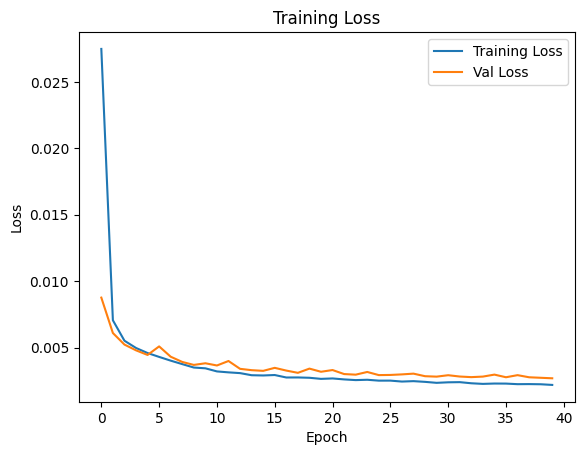

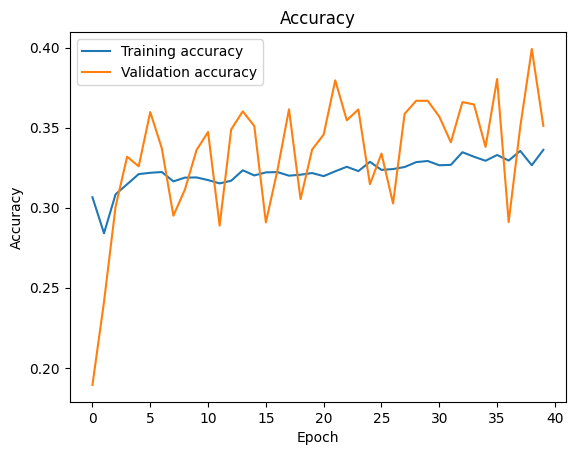

In [ ]:
printLosses(history_3)
printAccuracy(history_3)

#### Saving the weights to google drive

In [ ]:
autoencoder.save_weights('/content/drive/My Drive/autoencoder_weights_V3.h5')

#### Or load weights from file

In [ ]:
# Uploading the weights file
autoencoder_weights = files.upload()
autoencoder_weights_file_name = list(autoencoder_weights.keys())[0]

In [ ]:
autoencoder = build_autoencoder()
autoencoder.build(input_shape=(None, img_height_3, img_width_3, 3))
autoencoder.load_weights(autoencoder_weights_file_name)

#### Model Training Completed!
Now, let's verify whether the model has successfully captured the patterns present in the 'healthy' chest X-rays and if it can accurately detect anomalies.
Next, we will load a batch of 'sick' X-rays and assess how many of them are classified as anomalies by the model.

#### Checking if the reconstruction works well, Testing on a random NORMAL image from the 'test' dataset
We supposed to see a reconstructed image similier to te original image from the autoencoder model

1/1 [==============================] - 0s 351ms/step


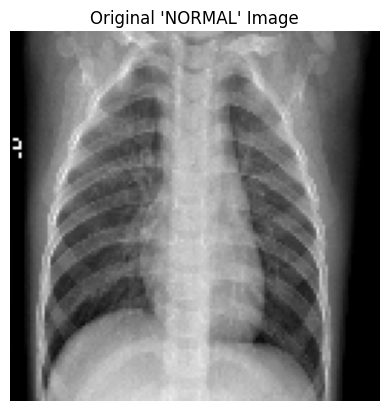

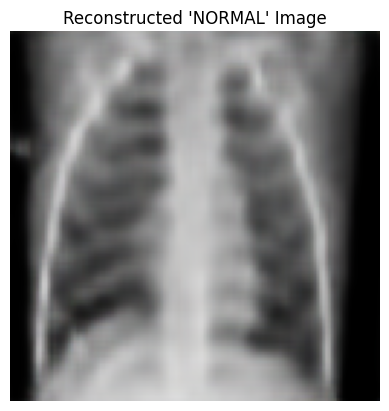

In [ ]:
def prepare_image(image_path, target_size=(128, 128)):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.astype('float32') / 255.
    img_array = tf.expand_dims(img_array, axis=0)
    return img_array.numpy()

normal_test_image = '/content/medical/chest_xray/test/NORMAL/' + random.choice(os.listdir('/content/medical/chest_xray/test/NORMAL/'))
test_image_normal = prepare_image(normal_test_image)
reconstructed_normal_test_image = autoencoder.predict(test_image_normal)


display_image(test_image_normal, "Original 'NORMAL' Image")
display_image(reconstructed_normal_test_image, "Reconstructed 'NORMAL' Image")

#### Checking on a random 'sick' image from the 'test' dataset to see how the reconstructed is on Data that the Model wasn't trained on.

1/1 [==============================] - 0s 19ms/step


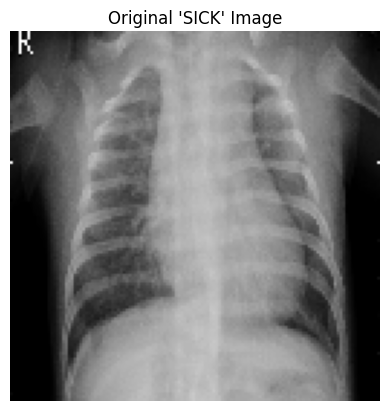

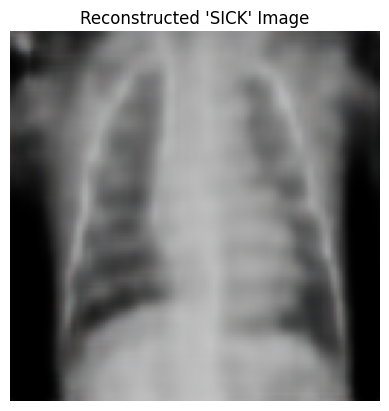

In [ ]:
sick_test_image = '/content/medical/chest_xray/test/PNEUMONIA/' + random.choice(os.listdir('/content/medical/chest_xray/test/PNEUMONIA/'))
test_image_sick = prepare_image(sick_test_image)
reconstructed_sick_test_image = autoencoder.predict(test_image_sick)

display_image(test_image_sick, "Original 'SICK' Image")
display_image(reconstructed_sick_test_image, "Reconstructed 'SICK' Image")

#### Function to calculate the loss between two images
it will calculate each image the MSE from the original image to the reconstructed image

In [ ]:
def calculate_loss(original_numpy_img, reconstructed_image):
    reconstruction_error = tf.keras.losses.mean_squared_error(original_numpy_img, reconstructed_image)
    reconstruction_error = np.mean(reconstruction_error)
    return reconstruction_error

#### Function to calculate the mean + standard devision of the test sample errors

In [ ]:
def calculate_mean_and_std(normal_data_errors):
    mean = np.mean(normal_data_errors)
    std = np.std(normal_data_errors)
    return mean, std

#### Function to given the mean and std + factor, return upperbound and lowerbound
This is setting the threshold

In [ ]:
def calculate_threshold(mean, std, factor):
    upper = mean + factor*std
    lower = mean - factor*std
    return lower, upper

#### Function that takes numpy_img + model + lst and add the error to the given lst

In [ ]:
def check_data_and_add_errors_to_list(numpy_img, model, lst):
    # Convert image tensor to numpy array
    img_tensor = tf.convert_to_tensor(numpy_img, dtype=tf.float32)
    # Pass the image through the autoencoder model
    reconstructed_img = model.predict(img_tensor, verbose=0)
    # Calculate the reconstruction error (e.g., using Mean Squared Error)
    reconstruction_error = calculate_loss(img_tensor, reconstructed_img)
    lst.append(reconstruction_error)

#### Defining the normal data errors
Taking all the "test" data that are classified as "Normal" and make up a list of all the errors for each one of the images.

In [ ]:
normal_error_lst = []
NORMAL_DATA_FOLDER = '/content/NORMAL_IMAGES/test/NORMAL'

folder_normal_files = os.listdir(NORMAL_DATA_FOLDER)
for file in folder_normal_files:
  if type(file) == str and "jpeg" in file:
    t = prepare_image(NORMAL_DATA_FOLDER + "/" + file)
    check_data_and_add_errors_to_list(t, autoencoder, normal_error_lst)


normal_error_mean, normal_error_std = calculate_mean_and_std(normal_error_lst)
print("Normal data mean:", normal_error_mean)
print("Normal data std:", normal_error_std)

Normal data mean: 0.002839874
Normal data std: 0.00072928524


#### Calculating the lower and upper bound given the mean + std

In [ ]:
lower, upper = calculate_threshold(normal_error_mean, normal_error_std, 1)
lower, upper

(0.0021105887717567384, 0.0035691592493094504)

**Explanation:**
Every image that will have it's result error between this range will consider "normal", otherwise will consider as anomaly

#### Checking what is the mean and std of the "sick" data. This is to show the differences between the "Normal" to the "Sick"
Puting in a list all the errors for each image

In [ ]:
sick_error_lst = []
SICK_DATA_FOLDER = '/content/medical/chest_xray/test/PNEUMONIA'

folder_sick_files = os.listdir(SICK_DATA_FOLDER)
for file in folder_sick_files:
  if type(file) == str and "jpeg" in file:
    t = prepare_image(SICK_DATA_FOLDER + "/" + file)
    check_data_and_add_errors_to_list(t, autoencoder, sick_error_lst)


sick_error_mean, sick_error_std = calculate_mean_and_std(sick_error_lst)
print("Sick data mean:", sick_error_mean)
print("Sick data std:", sick_error_std)

Sick data mean: 0.0022033402
Sick data std: 0.00085074676


#### Function that will recive all the information + path to image to calculate if this image is an anomaly. if it is an anomaly it will return True otherwise False

In [ ]:
def check_img_anomaly(img_path, model, lower, upper):
    t = prepare_image(img_path)
    # Convert image tensor to numpy array
    img_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
    # Pass the image through the autoencoder model
    reconstructed_img = model.predict(img_tensor, verbose=0)
    # Calculate the reconstruction error (e.g., using Mean Squared Error)
    reconstruction_error = calculate_loss(img_tensor, reconstructed_img)
    if reconstruction_error > upper or reconstruction_error < lower:
      # Anomaly
      return True
    else:
      # Normal
      return False

#### Checking the percentage of the anomaly detection that is "detecting" normal data as "anomaly"

In [ ]:
normal_counter = 0
for file in folder_normal_files:
  if "jpeg" in file:
    path = NORMAL_DATA_FOLDER + "/" + file
    f = check_img_anomaly(path, autoencoder, lower, upper)
    if f == True:
      normal_counter += 1

print("For the Normal data, it's detecting at ", normal_counter / len(folder_normal_files), "% images as 'Anomaly'")

For the Normal data, it's detecting at  0.27350427350427353 % images as 'Anomaly'


**As you can see only 27% of the "Normal" data are classified as 'Anomaly'**

#### Checking the percentage of the anomaly detection that is "detecting" sick data as "anomaly"

In [ ]:
sick_counter = 0
for file in folder_sick_files:
  if "jpeg" in file:
    path = SICK_DATA_FOLDER + "/" + file
    f = check_img_anomaly(path, autoencoder, lower, upper)
    if f == True:
      sick_counter += 1

print("For the Sick data, it's detecting at ", sick_counter / len(folder_sick_files), "% images as 'Anomaly'")

For the Sick data, it's detecting at  0.6358974358974359 % images as 'Anomaly'


**As you can see 63% of the "Sick" data are classified as 'Anomaly'**

## Task 4 - Visualizing Patches for Activation Maximization

1. Selecting the Model from Task 1.A
2. We will use image from the 'test/NORMAL' folder.
3. We will visual using Grad-CAM the convolution layers effect on the image.

**Reminders Model instance name is model_a**

**Note** both of the example are taking random images from the "test/NORMAL" folder at first and at the second from the "test/PNEUMONIA". incase there is sample that is classified as "PNEUMONIA" but is actually "NORMAL" or vice versa the reuslt will be different. the convolution layers acts different on different classification

#### Visual the convolution layers using GRAD-CAM
This is the gradcam algorithm, took from the following source:
https://keras.io/examples/vision/grad_cam/

It is displaying the convolution layer effect on the image with a friendly view

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # print(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

#### The algorithm for displaying the gradcam + saving the image as well

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=1, title="title"):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.title(title)
    plt.imshow(np.array(Image.open(cam_path).resize((256, 256))))
    plt.show()


#### The gradcam visual algorithm.
Recving a model, list of layers, and list of labels (more as well) and displaying the effect of each layer on the input image. as a heatmap

In [ ]:
def visualize_heatmaps(img_array, model, layers_name, img_size_a, class_labels_a, lst, preds):
    fig, axes = plt.subplots(1, len(layers_name) + 1, figsize=(20, 5))

    # Display the original image
    axes[0].imshow(img_array[0])
    axes[0].axis('off')
    axes[0].set_title('Original Image : ' + getPreidictionLabel(preds, class_labels_a))

    # Iterate over convolutional layers and display heatmaps
    for i, conv_layer in enumerate(layers_name, start=1):
        heatmap = make_gradcam_heatmap(img_array, model, conv_layer, 0)
        # print(heatmap)
        lst.append(heatmap)
        axes[i].imshow(heatmap)
        axes[i].axis('off')
        axes[i].set_title(f'Heatmap - {conv_layer}')

    plt.tight_layout()
    plt.show()

#### Reminder of model 1.A Architecture

In [ ]:
model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

#### All the layers in the Model 1.A

##### Extracting all the convolution layers name

In [ ]:
layers_name = []
for layer in model_a.layers:
  if 'conv' in layer.name:
    layers_name.append(layer.name)
layers_name

['conv2d', 'conv2d_1', 'conv2d_2']

#### Preparing the input image for the visualization
Taking a random test 'NORMAL' x-ray for this visualization

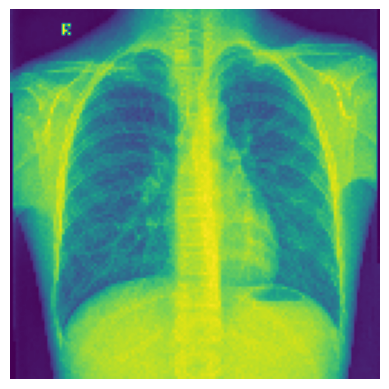

(None, (1, 128, 128, 1))

In [ ]:
# Loading sample image from he 'test' folder
input_image_path = '/content/medical/chest_xray/test/NORMAL/' + random.choice(os.listdir('/content/medical/chest_xray/test/NORMAL/'))
input_image = prepareImgToModel(input_image_path, img_size_a)
ShowImg(input_image.squeeze()), input_image.shape

##### Displaying the original image along with the heatmap of each convolution layer

1/1 [==============================] - 0s 35ms/step


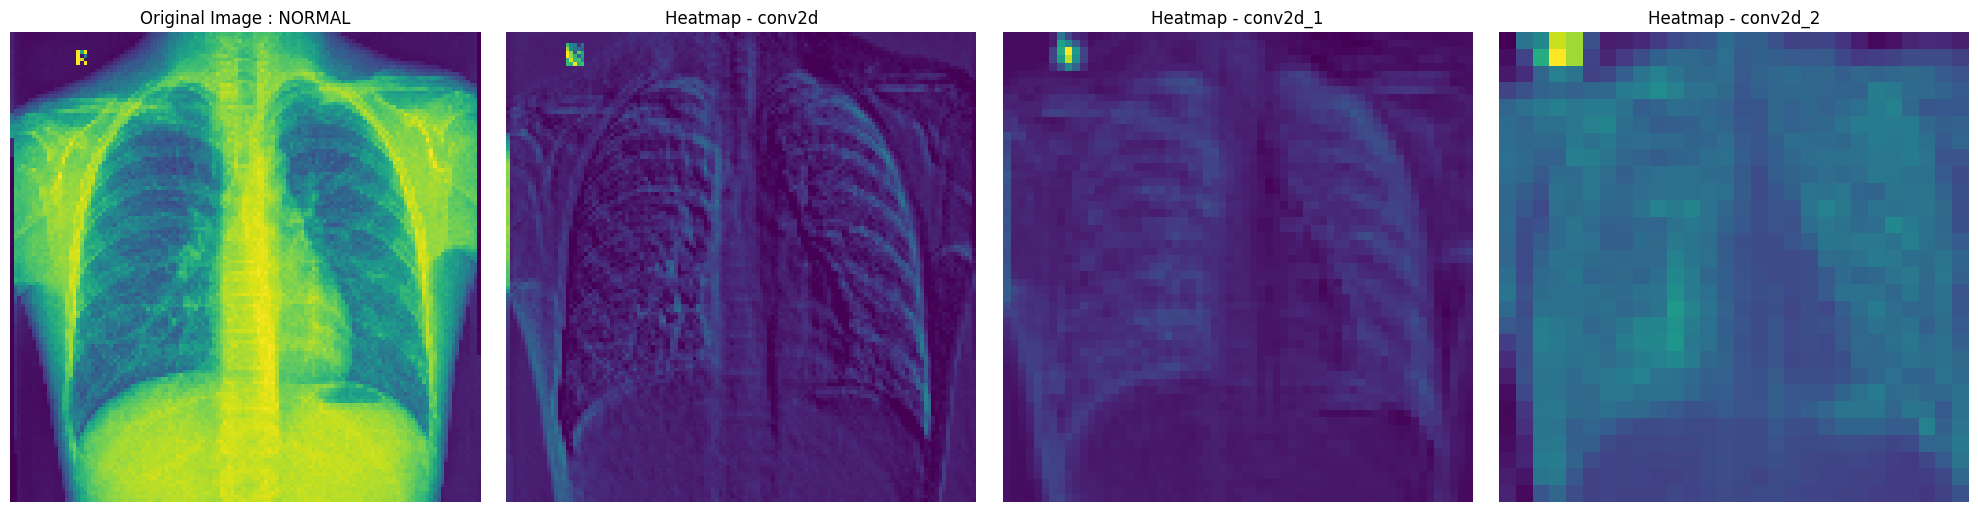

In [ ]:
img_array = prepareImgToModel(input_image_path, img_size_a)
preds = model_a.predict(img_array)
heatMapsLst = []
visualize_heatmaps(img_array, model_a, layers_name, img_size_a, class_labels_a, heatMapsLst, preds)

##### Showing the original image + heatmap on top of them + saving them to the folder

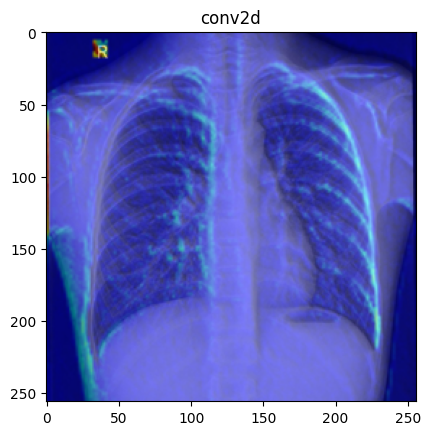

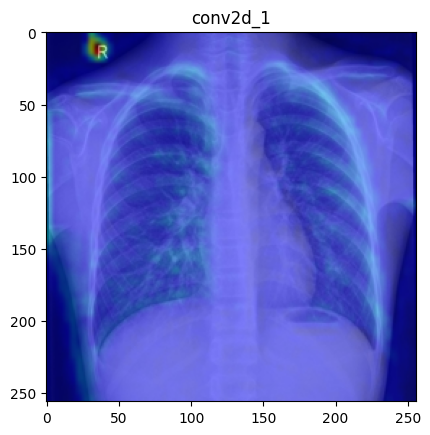

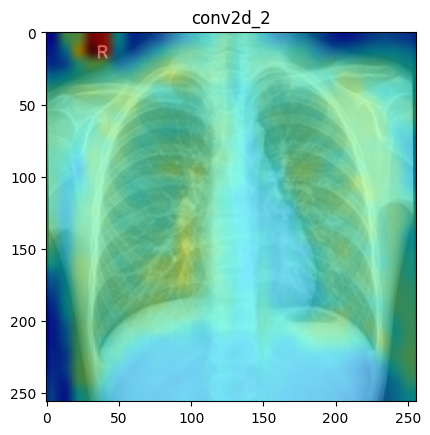

In [ ]:
for i in range(len(heatMapsLst)):
  save_and_display_gradcam(input_image_path, heatMapsLst[i], layers_name[i] + ".jpg", title=layers_name[i])

#### Lets Test with another example
Here we will take an image from the 'train' set that is classified as penumonia for this example

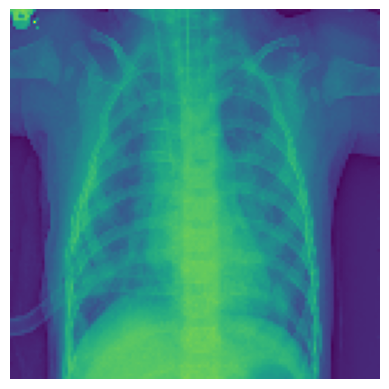

(None, (1, 128, 128, 1))

In [ ]:
# Loading sample image from he 'test' folder
input_image_path_2 = '/content/medical/chest_xray/test/PNEUMONIA/' + random.choice(os.listdir('/content/medical/chest_xray/test/PNEUMONIA/'))
input_image_2 = prepareImgToModel(input_image_path_2, img_size_a)
ShowImg(input_image_2.squeeze()), input_image_2.shape

1/1 [==============================] - 0s 61ms/step


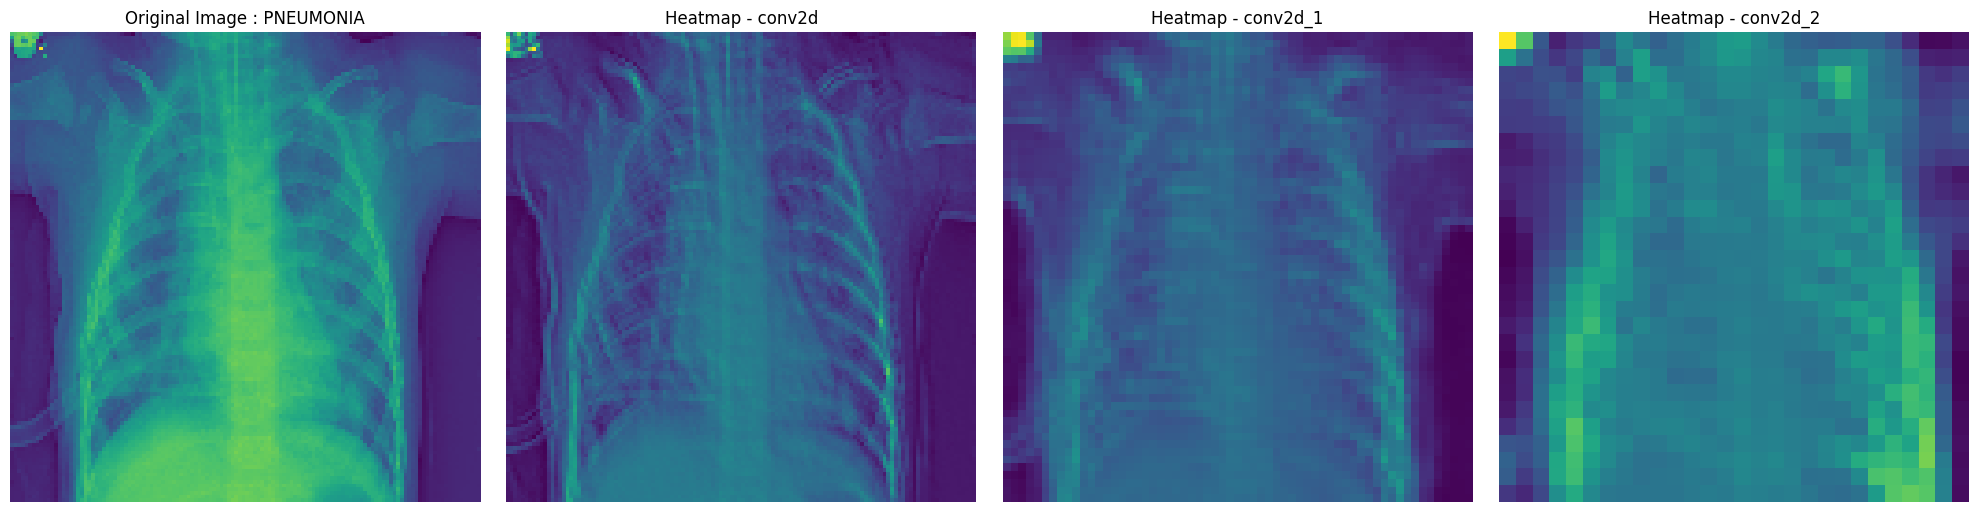

In [ ]:
img_array_2 = prepareImgToModel(input_image_path_2, img_size_a)
preds_2 = model_a.predict(img_array_2)
heatMapsLst_2 = []
visualize_heatmaps(img_array_2, model_a, layers_name, img_size_a, class_labels_a, heatMapsLst_2, preds_2)

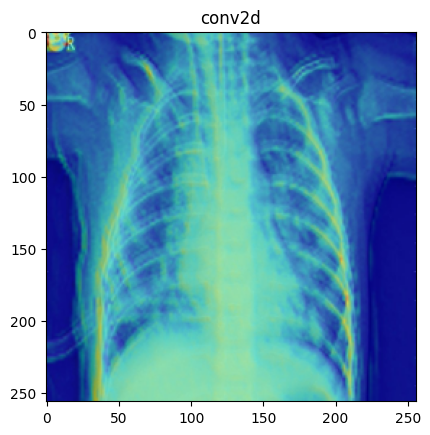

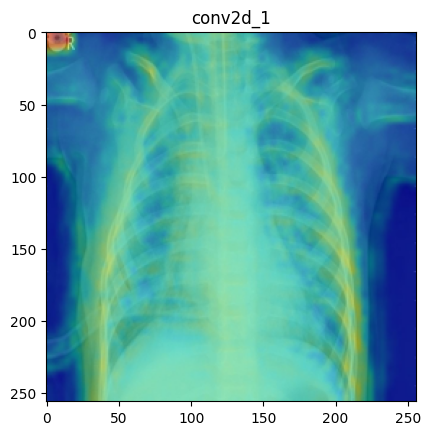

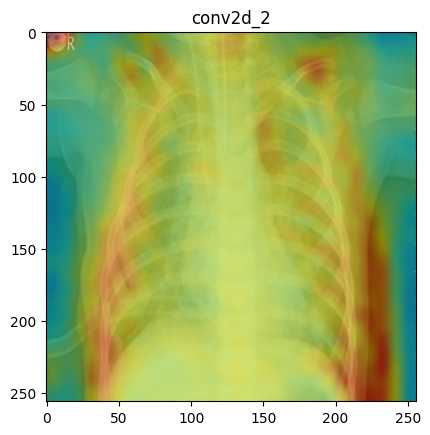

In [ ]:
for i in range(len(heatMapsLst_2)):
  save_and_display_gradcam(input_image_path_2, heatMapsLst_2[i], layers_name[i] + ".jpg", title=layers_name[i])

#### Interpretation of Convolutional Neural Network Visualizations

In this study, we employed a convolutional neural network (CNN) architecture to perform image classification tasks. The CNN architecture consisted of several convolutional layers (And more..). We visualized only the convolution layers.
